In [16]:
from __future__ import print_function
#%matplotlib inline
import argparse
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import HTML
import pandas as pd
import data_utils.data_utils_celeba_pytorch5 as data_utils
import data_utils.network_tuning_valid as network_tuning
from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd
import pickle
# Load functions
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout2d, MaxPool2d, BatchNorm2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [17]:
IMAGE_SHAPE = [73,60,3]
# Root directory for dataset
dataroot = 'C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness'
# Paths to data
VALID_PATH = dataroot + "\\Data\\valid.csv"  
IMAGE_PATHS = "C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\celebA_resize3\\"
TARGET_COL = 'Smiling' #'Smiling'
NUM_CLASSES = 2

# valid data
data_valid = data_utils.CelebADataset(VALID_PATH,IMAGE_PATHS,IMAGE_SHAPE,TARGET_COL)

In [18]:
attributes = pd.read_csv('C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness\\Data\\list_attr_celeba.txt', sep=" ")
attributes.drop('Unnamed: 41',axis=1, inplace=True)
partition = pd.read_csv('C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\list_eval_partition.txt', sep=" ", header=None, names=['im_id','partition'])
matched = attributes.set_index('im_id').join(partition.set_index('im_id')).replace(-1,0)

valid_df = matched[matched['partition']==1]

In [19]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

No GPU available.


In [20]:
criterion = nn.CrossEntropyLoss()          #<-- Your code here.   

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

In [21]:
# Function to get label
def get_labels(batch):
    return get_variable(Variable(batch['target']))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(batch['image']))
    }

In [7]:
# Read dataframe with training metrics
df = pd.read_pickle('aws\\Models\\run1_martin_df.pkl') #e.g. pd.read_pickle('df.pkl')

In [57]:
df.loc[3,'activations']

[<function torch.nn.functional.relu(input, inplace=False)>,
 <function torch.nn.functional.relu(input, inplace=False)>,
 <function torch.nn.functional.relu(input, inplace=False)>,
 <function torch.nn.functional.relu(input, inplace=False)>]

In [8]:
df

,layers,activations,conv_out_channels,kernel_size,conv_stride,maxpool,dropout,batchnorm,optimizer,learning_rate,weight_decay,batch_size,num_epochs,net,train_loss,train_accs,valid_train_loss,valid_train_accs,valid_loss,valid_accs
1,2,"[<function relu at 0x000001C980CD3E18>, <funct...",32,5,1,1,0.0,False,Adam,0.001,0.0,128,5,run1_martin_model1,"[0.7146734595298767, 5.96096658706665, 6.03815...","[0.5078125, 0.546875, 0.515625, 0.7421875, 0.6...","[0.8009383082389832, 0.5955037474632263, 0.384...","[0.4842703938484192, 0.8434086441993713, 0.870...",0.212693,0.910807
2,2,"[<function relu at 0x000001C980CD3E18>, <funct...",64,5,1,1,0.0,False,Adam,0.001,0.0,128,5,run1_martin_model2,"[0.6914783716201782, 15.70244026184082, 36.217...","[0.5078125, 0.5625, 0.5, 0.4453125, 0.6328125,...","[0.7138357758522034, 1.0319395065307617, 0.725...","[0.49061256647109985, 0.8488951325416565, 0.86...",0.227125,0.907334
3,2,"[<function relu at 0x000001C980CD3E18>, <funct...",32,5,1,1,0.0,False,Adam,0.001,0.0,128,5,run1_martin_model3,"[0.6933189034461975, 17.534706115722656, 11.21...","[0.5390625, 0.5625, 0.46875, 0.5703125, 0.5, 0...","[3.6073431968688965, 0.22339202463626862, 0.21...","[0.4773241877555847, 0.9045653343200684, 0.908...",0.231187,0.906679
4,2,"[<function relu at 0x000001C980CD3E18>, <funct...",64,5,1,1,0.0,False,Adam,0.001,0.0,128,5,run1_martin_model4,"[0.7271662950515747, 93.59306335449219, 17.855...","[0.453125, 0.4921875, 0.59375, 0.46875, 0.4921...","[7.938321590423584, 0.2576132118701935, 0.2166...","[0.5079277157783508, 0.8980721831321716, 0.909...",0.228668,0.907787
5,1,"[<function tanh at 0x000001C980CD48C8>, <funct...",32,5,1,1,0.0,False,Adam,0.001,0.0,128,5,run1_martin_model5,"[0.7636500597000122, 6.108983516693115, 3.4058...","[0.5234375, 0.53125, 0.609375, 0.5, 0.671875, ...","[0.8202677369117737, 2.509509801864624, 1.4084...","[0.4853777587413788, 0.8198519945144653, 0.858...",0.2698,0.885841
6,1,"[<function tanh at 0x000001C980CD48C8>, <funct...",128,5,1,1,0.0,False,Adam,0.001,0.0,128,5,run1_martin_model6,"[0.8382572531700134, 13.698846817016602, 19.70...","[0.46875, 0.640625, 0.5625, 0.5546875, 0.67968...","[0.7192241549491882, 8.831503868103027, 11.681...","[0.5089847445487976, 0.7916142344474792, 0.842...",0.260439,0.896713
7,2,"[<function tanh at 0x000001C980CD48C8>, <funct...",32,5,1,1,0.0,False,Adam,0.001,0.0,128,5,run1_martin_model7,"[0.7210633158683777, 27.723573684692383, 1.008...","[0.4375, 0.46875, 0.640625, 0.5, 0.4453125, 0....","[0.714911699295044, 0.268008291721344, 0.29748...","[0.4878945052623749, 0.8858911991119385, 0.872...",0.248401,0.8947
8,2,"[<function tanh at 0x000001C980CD48C8>, <funct...",64,5,1,1,0.0,False,Adam,0.001,0.0,128,5,run1_martin_model8,"[0.7142513394355774, 54.387603759765625, 2.152...","[0.4921875, 0.4609375, 0.640625, 0.59375, 0.53...","[0.7034733295440674, 0.3434240520000458, 0.240...","[0.516383945941925, 0.8509588837623596, 0.8995...",0.241064,0.898374
9,2,"[<function tanh at 0x000001C980CD48C8>, <funct...",32,5,1,1,0.0,False,Adam,0.001,0.0,128,5,run1_martin_model9,"[0.7225079536437988, 5.823354244232178, 1.4886...","[0.4453125, 0.5625, 0.6875, 0.640625, 0.6875, ...","[0.7015874981880188, 0.5521948933601379, 0.692...","[0.49398499727249146, 0.833543062210083, 0.868...",0.529673,0.881009
10,2,"[<function tanh at 0x000001C980CD48C8>, <funct...",64,5,1,1,0.0,False,Adam,0.001,0.0,128,5,run1_martin_model10,"[0.7297398447990417, 8.323760032653809, 8.3655...","[0.453125, 0.53125, 0.640625, 0.65625, 0.57812...","[0.7187111377716064, 1.0636043548583984, 1.320...","[0.4739517867565155, 0.8660593032836914, 0.849...",0.814015,0.874566


In [14]:
[np.mean(df.loc[i,'train_accs'][-300:]) for i in range(1,11)]

[0.913644562959671,
 0.9093362549940746,
 0.9301206807295481,
 0.9236331299940745,
 0.9013789379596711,
 0.9199288616577784,
 0.901457062959671,
 0.8930049542586008,
 0.8670153709252676,
 0.8355621188879013]

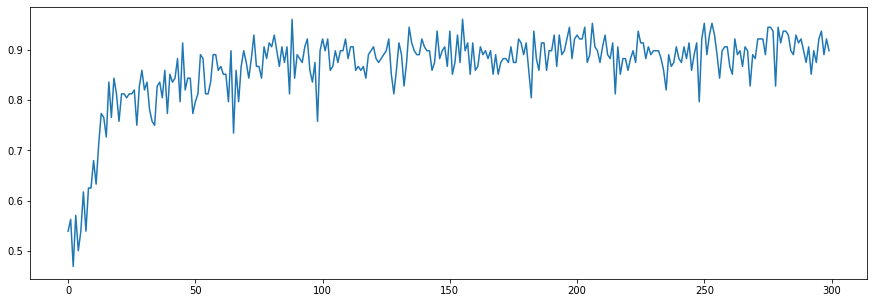

In [59]:
plt.figure(figsize=(15,5))
plt.plot(df.loc[3,'train_accs'][0:300])
ind = [300*i for i in range(0,22)]
#plt.plot(ind,df.loc[3,'valid_train_accs'])

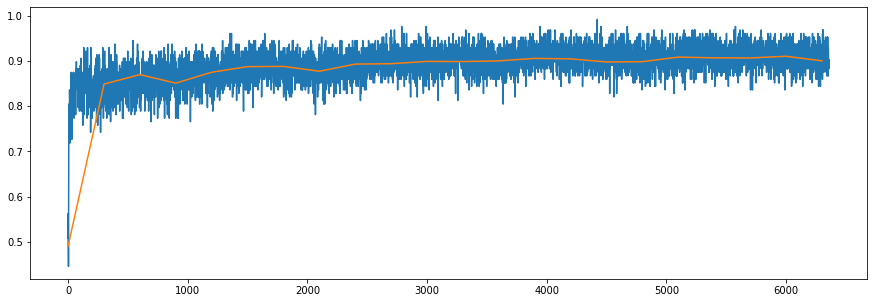

In [46]:
plt.figure(figsize=(15,5))
plt.plot(df.loc[2,'train_accs'])
ind = [300*i for i in range(0,22)]
plt.plot(ind,df.loc[2,'valid_train_accs'])

In [10]:
# Change i to the model number you want to load
i = 1
IMAGE_SHAPE = [73,60,3]
layers = df.loc[i,'layers']
activations = df.loc[i,'activations']
conv_out_channels = df.loc[i,'conv_out_channels']
kernel_size = df.loc[i,'kernel_size']
conv_stride = df.loc[i,'conv_stride']
maxpool = int(df.loc[i,'maxpool'])
dropout = df.loc[i,'dropout']
batchnorm = df.loc[i,'batchnorm']
optimizer = df.loc[i,'optimizer']
learning_rate = df.loc[i,'learning_rate']
weight_decay = df.loc[i,'weight_decay']
batch_size = int(df.loc[i,'batch_size'])
num_epochs = df.loc[i,'num_epochs']

net = network_tuning.tune_architecture(layers, activations, IMAGE_SHAPE, conv_out_channels, kernel_size,conv_stride, maxpool, dropout, batchnorm)

In [14]:
# Load network, choose the model i
net.load_state_dict(torch.load('aws\\Models\\run1_martin_model1.dms',map_location=torch.device('cpu'))) # e.g. net.load_state_dict(torch.load('model1'))
net.eval()

Net(
  (conv_1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.0, inplace=False)
  (l_out): Linear(in_features=216320, out_features=2, bias=False)
)

In [23]:
#dataframe for saving predictions
valid_predictions = valid_df.astype(object)
valid_predictions.loc[:,'target'] = valid_predictions.loc[:,'Smiling']
valid_predictions.drop(['Smiling','partition'],axis=1)
valid_predictions['output'] = np.nan
valid_predictions['labels_argmax'] = np.nan
valid_predictions['accuracy'] = np.nan
valid_predictions['criterion'] = np.nan

In [24]:
#calculation predictions on the validation set
batch_gen_valid = DataLoader(data_valid, batch_size, shuffle=True, num_workers=6)
val_1_losses,val_1_accs,val_1_lengths,val_0_losses,val_0_accs,val_0_lengths = 0, 0, 0, 0, 0, 0
valid_predictions = valid_predictions.astype(object)
with torch.no_grad():
    for batch_valid in batch_gen_valid:
        output = net(**get_input(batch_valid))
        labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
        for i in range(len(batch_valid['file'])):
            valid_predictions.at[batch_valid['file'][i],'output'] = output['out'][i]
            valid_predictions.at[batch_valid['file'][i],'labels_argmax'] = labels_argmax[i]
            valid_predictions.at[batch_valid['file'][i],'accuracy'] = accuracy(output['out'][i:i+1],labels_argmax[i:i+1])
            valid_predictions.at[batch_valid['file'][i],'criterion'] = criterion(output['out'][i:i+1],labels_argmax[i:i+1])

C:\Users\cfthe\Anaconda3\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [25]:
# Should be equalt to validation accuracy in df
np.mean(valid_predictions['accuracy'])

0.9108068656566165

In [26]:
#calculating accuracies for all protected attributes
attributes = matched.iloc[:,0:-1].drop('Smiling',axis=1).columns
df_att = pd.DataFrame(index = attributes, columns=['val_1_loss','val_1_acc','val_0_loss','val_0_acc','val_1_FP','val_1_TP','val_0_FP','val_0_TP'])
batch_gen_valid = DataLoader(data_valid, batch_size, shuffle=True, num_workers=6)
for att in range(0,len(attributes)):
    print(attributes[att])
    
    att_ = valid_predictions.iloc[:][attributes[att]]
    t_ = valid_predictions.iloc[:]['target']
    
    att_1 = np.where(att_==1)
    att_0 = np.where(att_==0)
    
    att_1_t_1 = np.where((att_==1) & (t_==1))
    att_0_t_1 = np.where((att_==0) & (t_==1))
    att_1_t_0 = np.where((att_==1) & (t_==0))
    att_0_t_0 = np.where((att_==0) & (t_==0))
    
    df_att.iloc[att]['val_1_loss'] = np.mean(valid_predictions.iloc[att_1]['criterion'])
    df_att.iloc[att]['val_1_acc'] = np.mean(valid_predictions.iloc[att_1]['accuracy'])
    df_att.iloc[att]['val_0_loss'] = np.mean(valid_predictions.iloc[att_0]['criterion'])
    df_att.iloc[att]['val_0_acc'] = np.mean(valid_predictions.iloc[att_0]['accuracy'])
    df_att.iloc[att]['val_1_FP'] = 1-np.mean(valid_predictions.iloc[att_1_t_0]['accuracy'])
    df_att.iloc[att]['val_0_FP'] = 1-np.mean(valid_predictions.iloc[att_0_t_0]['accuracy'])
    df_att.iloc[att]['val_1_TP'] = np.mean(valid_predictions.iloc[att_1_t_1]['accuracy'])
    df_att.iloc[att]['val_0_TP'] = np.mean(valid_predictions.iloc[att_0_t_1]['accuracy'])

5_o_Clock_Shadow
Arched_Eyebrows
Attractive
Bags_Under_Eyes
Bald
Bangs
Big_Lips
Big_Nose
Black_Hair
Blond_Hair
Blurry
Brown_Hair
Bushy_Eyebrows
Chubby
Double_Chin
Eyeglasses
Goatee
Gray_Hair
Heavy_Makeup
High_Cheekbones
Male
Mouth_Slightly_Open
Mustache
Narrow_Eyes
No_Beard
Oval_Face
Pale_Skin
Pointy_Nose
Receding_Hairline
Rosy_Cheeks
Sideburns
Straight_Hair
Wavy_Hair
Wearing_Earrings
Wearing_Hat
Wearing_Lipstick
Wearing_Necklace
Wearing_Necktie
Young


In [61]:
df_att['TP_OR'] = df_att['val_1_TP'] /df_att['val_0_TP'] 
df_att['FP_OR'] = df_att['val_1_FP'] /df_att['val_0_FP'] 
df_att['TP_OR'] = pd.to_numeric(df_att['TP_OR'])
df_att['FP_OR'] = pd.to_numeric(df_att['FP_OR'])

In [62]:
df_att

,val_1_loss,val_1_acc,val_0_loss,val_0_acc,val_1_FP,val_1_TP,val_0_FP,val_0_TP,TP_OR,FP_OR
5_o_Clock_Shadow,0.207645,0.916418,0.213367,0.910056,0.0853574,0.919248,0.0984814,0.918717,1.000578,0.866736
Arched_Eyebrows,0.179421,0.921893,0.224286,0.906944,0.112112,0.94782,0.092367,0.906115,1.046027,1.213763
Attractive,0.196156,0.917151,0.230613,0.903933,0.091796,0.924081,0.100434,0.910582,1.014825,0.913990
Bags_Under_Eyes,0.207228,0.911915,0.214122,0.910517,0.136255,0.944603,0.0889638,0.909892,1.038148,1.531572
Bald,0.283375,0.885645,0.211199,0.911338,0.176166,0.940367,0.0951152,0.918265,1.024069,1.852131
Bangs,0.176204,0.925901,0.218967,0.908211,0.0860058,0.936487,0.0982795,0.915374,1.023065,0.875114
Big_Lips,0.183321,0.919842,0.218007,0.909172,0.0905301,0.932601,0.0978337,0.916474,1.017596,0.925347
Big_Nose,0.222252,0.907748,0.209526,0.91182,0.136452,0.939121,0.0866918,0.909999,1.032003,1.573992
Black_Hair,0.218005,0.90999,0.211292,0.911022,0.0891089,0.908949,0.0987194,0.921224,0.986675,0.902649
Blond_Hair,0.211666,0.907723,0.212879,0.911368,0.115481,0.922622,0.0941566,0.91784,1.005210,1.226480


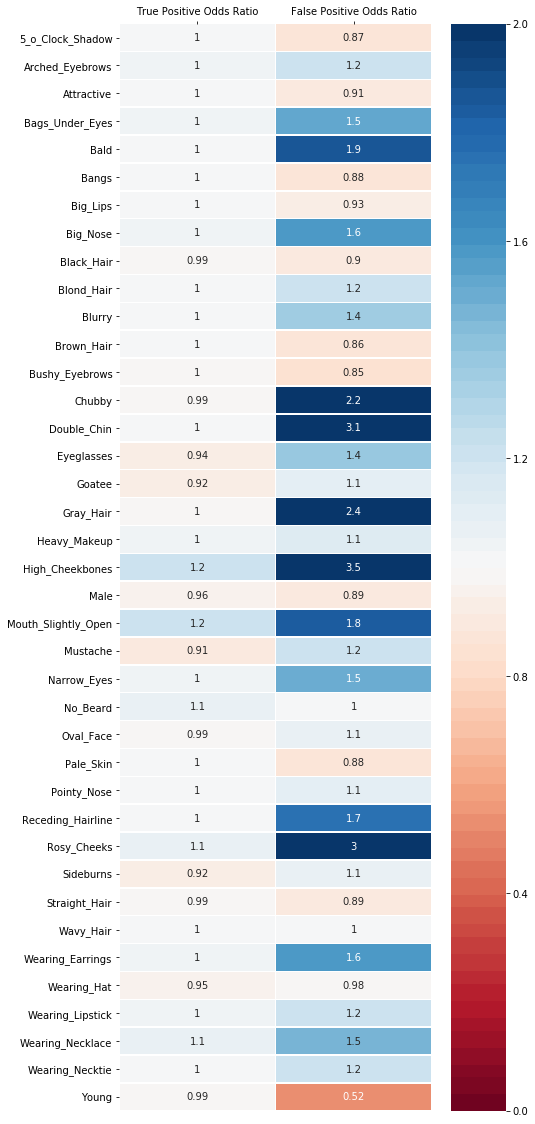

In [63]:

plt.figure(figsize = (7,20))
cmap=sns.color_palette("RdBu",70)
heatmap_kwargs = dict(vmin=0, vmax=2, cmap=cmap,annot=True, linewidths=.5)
ax = sns.heatmap(df_att[['TP_OR','FP_OR']], center=1.0, **heatmap_kwargs)
ax.set_xticklabels(['True Positive Odds Ratio','False Positive Odds Ratio'])
ax.set_yticklabels(list(df_att.index))
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.xaxis.set_ticks_position('top')

In [1]:
73*60

4380

In [22]:
import math
def conv_dim(dim_size):
    return int(math.ceil(dim_size - 5 + 2 * 0 / 1 + 1))

In [23]:
conv_dim(73)//2

34

In [24]:
conv_dim(60)//2

28

In [25]:
conv_dim(34)//2

15

In [26]:
conv_dim(28)//2

12

In [14]:
15*12

180

In [15]:
180*64

11520